'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


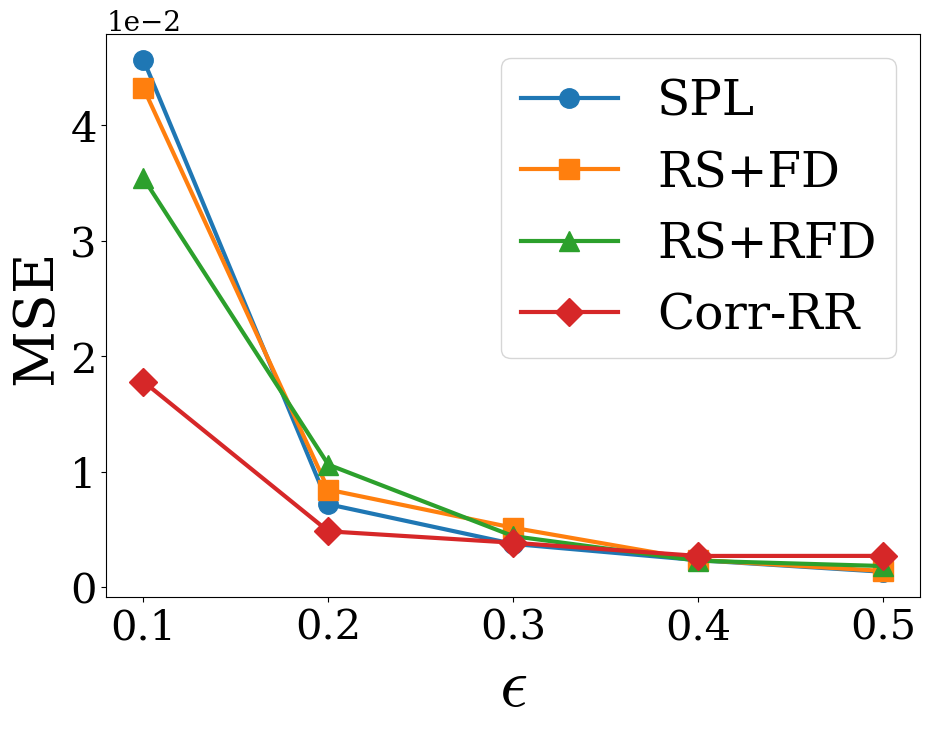

In [26]:
import sys, os





# Detect if running inside Jupyter
if "__file__" in globals():
    # Running as a .py script
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    # Running inside Jupyter Notebook
    # Assume notebook is inside project/reproduction/
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from utils.data_utils_newest import gen_star_from_x1, get_true_frequencies, gen_progressive
from utils.metrics import compute_mse
from utils.spl import random_split_perturb, random_split_estimate
from utils.rs_fd import rs_fd_perturb, rs_fd_estimate
from utils.rs_rfd import rs_rfd_perturb, rs_rfd_estimate
from utils.corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)



mpl.rcParams['pdf.fonttype'] = 42   # TrueType
mpl.rcParams['ps.fonttype'] = 42    # TrueType for EPS


mpl.rc('font', family='DejaVu Serif')


mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['mathtext.fontset'] = 'cm'     # Math font
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30
# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}



def build_p_y_table(est_I, epsilon, n2, domain, cols):
    table = {}
    for a in cols:
        for b in cols:
            if a != b:
                table[(a, b)] = float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
    return table
# ----------------------------------------------------------
# One-shot: run SPL, RS+FD, RS+RFD, Corr-RR on a real dataset
# ----------------------------------------------------------
def run_all_once(df, epsilon, frac_corr=0.1, frac_rsrfd=0.1):
    cols = df.columns.tolist()
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # === SPL ===
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # === RS+FD ===
    pert_fd = rs_fd_perturb(df, domains, epsilon)
    est_fd = rs_fd_estimate(pert_fd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_fd[c]) for c in cols])

    # === RS+RFD (two-phase) ===
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_rsrfd)
    n1_r = len(df) - len(df_B_rsrfd)
    n2_r = len(df_B_rsrfd)
    priors = {col: normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}

    pert_rfd = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors, epsilon)
    est_II_r = rs_rfd_estimate(pert_rfd, doms_rsrfd, priors, epsilon)

    combined_rfd = combine_phase_estimates(est_I_rsrfd, est_II_r, n1_r, n2_r)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rfd[c]) for c in cols])

    # === Corr-RR ===
    est_I, df_B, doms = corr_rr_phase1_spl(df, epsilon, frac=frac_corr)
    n1 = len(df) - len(df_B)
    n2 = len(df_B)

    common_domain = doms[cols[0]]
    p_y_table = build_p_y_table(est_I, epsilon, n2, common_domain, cols)

    pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms, p_y_table)
    est_II = corr_rr_estimate(pert_corr, doms, epsilon)

    combined_corr = combine_phase_estimates(est_I, est_II, n1, n2)
    out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_corr[c]) for c in cols])

    return out


# ----------------------------------------------------------
# Sweep epsilon on a real dataset
# ----------------------------------------------------------
def sweep_realworld(
    df,
    epsilons,
    R=5,
    frac_corr=0.1,
    frac_rsrfd=0.1,
    plot_dir=None,
    csv_dir=None,
    file="realworld_plot"
):
    keys = ["SPL", "RS+FD", "RS+RFD", "Corr-RR"]
    means = {k: np.zeros(len(epsilons)) for k in keys}

    for run in range(R):
        for j, eps in enumerate(epsilons):
            res = run_all_once(df, eps, frac_corr, frac_rsrfd)
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # ------------------------------------------------------
    # Plotting
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    for k, marker in zip(keys, ['o', 's', '^', 'D']):
        plt.plot(epsilons, means[k], f'-{marker}', linewidth=3, markersize=14, label=k)




    plt.xlabel(r"$\epsilon$", fontsize=50)
    plt.ylabel("MSE", fontsize=40)

    # ✨ Force scientific notation on the x-axis
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    plt.xticks(epsilons, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=35)
    plt.tight_layout()

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, file + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        dfout = pd.DataFrame({"epsilon": epsilons})
        for k in keys:
            dfout[k] = means[k]
        dfout.to_csv(os.path.join(csv_dir, file + ".csv"), index=False)

    return means


# ----------------------------------------------------------
# MAIN: Change only dataset_name to run full experiment
# ----------------------------------------------------------
if __name__ == "__main__":

    dataset_name = "clave_10k"   # <<< change to: "clave" or "mushroom"
    dataset_path = f"{project_root}/preprocessed_real_data/{dataset_name}.csv"

    df = pd.read_csv(dataset_path)

    eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]

    sweep_realworld(
        df=df,
        epsilons=eps_list,
        R=50,
        frac_corr=0.1,
        frac_rsrfd=0.1,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
        file="fig_11a",
    )


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


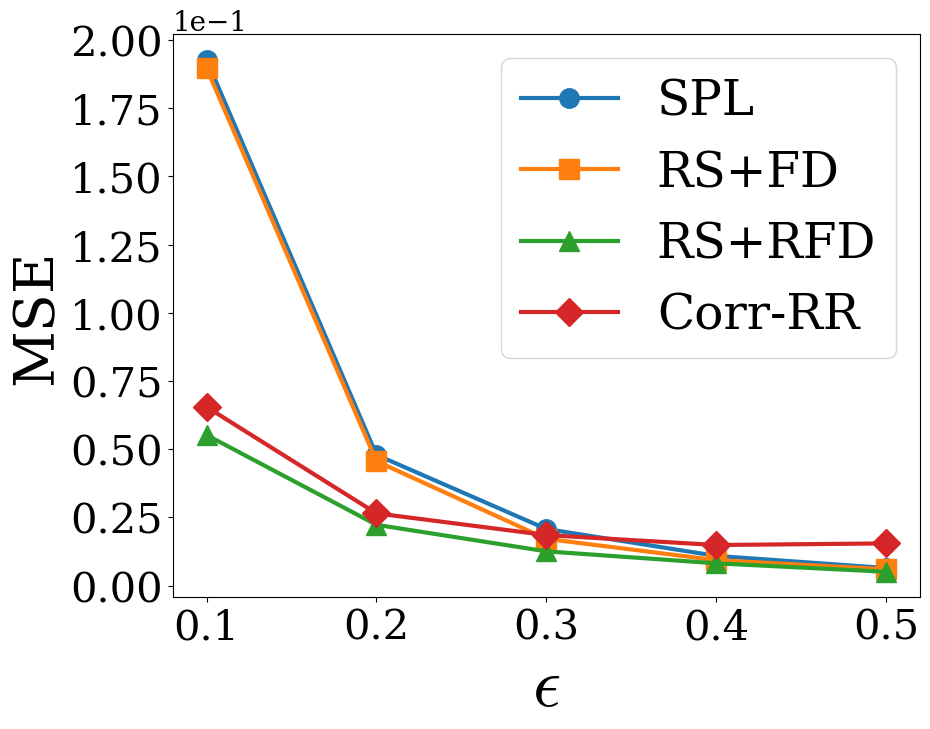

In [27]:
if __name__ == "__main__":

    dataset_name = "mushroom_10k"   # <<< change to: "clave" or "mushroom"
    dataset_path = f"{project_root}/preprocessed_real_data/{dataset_name}.csv"

    df = pd.read_csv(dataset_path)

    eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]

    sweep_realworld(
        df=df,
        epsilons=eps_list,
        R=50,
        frac_corr=0.1,
        frac_rsrfd=0.1,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
        file="fig_11b",
    )


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


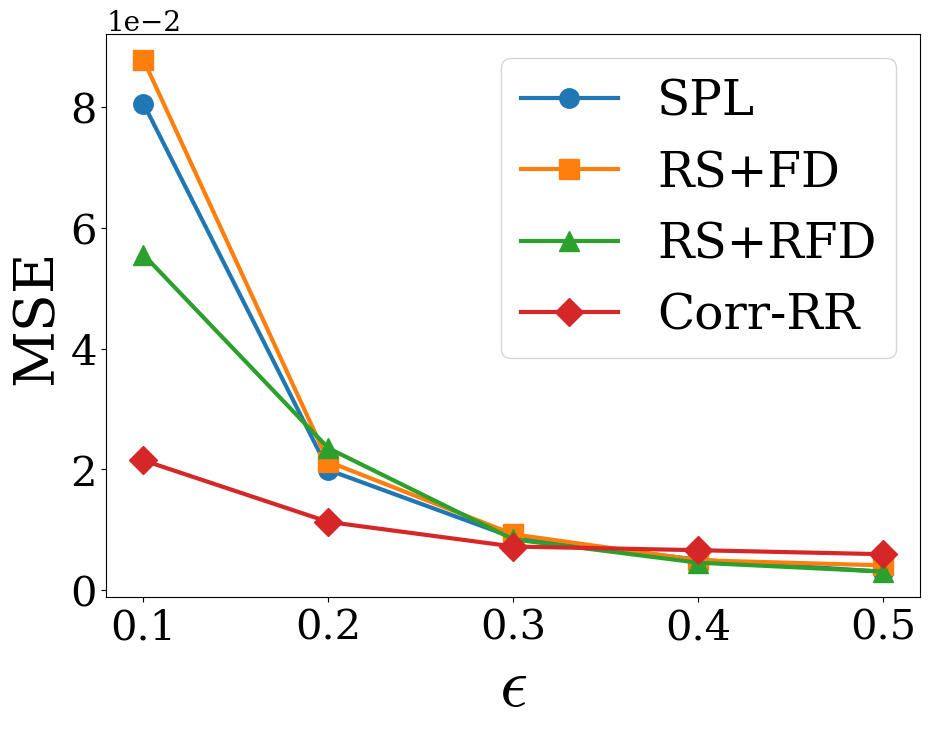

In [25]:
if __name__ == "__main__":

    dataset_name = "adult_10k"   # <<< change to: "clave" or "mushroom"
    dataset_path = f"{project_root}/preprocessed_real_data/{dataset_name}.csv"

    df = pd.read_csv(dataset_path)

    eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]

    sweep_realworld(
        df=df,
        epsilons=eps_list,
        R=50,
        frac_corr=0.1,
        frac_rsrfd=0.1,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
        file="fig_11c",
    )